# Import Libraries

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score

from art.utils import load_cifar10
from art.defences.preprocessor import CutoutTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
tf.config.run_functions_eagerly(True)

# Load Data

In [5]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

# CutOut

In [13]:
cutout = CutoutTensorFlowV2(length=6, apply_fit=True, apply_predict=False)

In [18]:
cutout_train = cutout.forward(x=x_train, y=y_train)

In [26]:
cutout_test = cutout.forward(x=x_test, y=y_test)

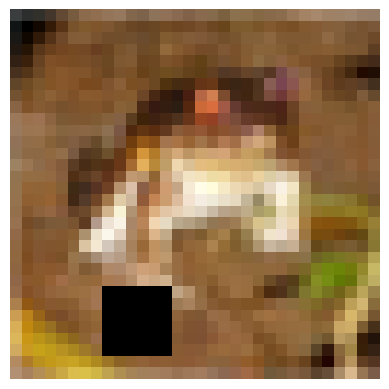

In [21]:
plt.figure()
plt.imshow(cutout_train[0][0])
plt.axis("off")
plt.show()

# Model

In [22]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        Conv2D(32, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        
        Dense(512, activation="relu"),
        Dense(10, activation="softmax")
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [23]:
normal_model = create_model()

In [24]:
augmented_model = create_model()

# Train - Normal Model

In [25]:
history = normal_model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 8s 12ms/step - loss: 1.4284 - accuracy: 0.4844 - val_loss: 1.0620 - val_accuracy: 0.6274
Epoch 2/10
391/391 [==============================] - 4s 9ms/step - loss: 0.9548 - accuracy: 0.6633 - val_loss: 0.8936 - val_accuracy: 0.6896
Epoch 3/10
391/391 [==============================] - 4s 9ms/step - loss: 0.7446 - accuracy: 0.7415 - val_loss: 0.7663 - val_accuracy: 0.7321
Epoch 4/10
391/391 [==============================] - 4s 9ms/step - loss: 0.5831 - accuracy: 0.7976 - val_loss: 0.8030 - val_accuracy: 0.7306
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.4372 - accuracy: 0.8475 - val_loss: 0.7764 - val_accuracy: 0.7586
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2976 - accuracy: 0.8965 - val_loss: 0.8646 - val_accuracy: 0.7555
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.1720 - accuracy: 0.9410 - val_loss: 1.0168 - val_accuracy: 0.7444
Ep

# Train - Augmented Model

In [30]:
history = augmented_model.fit(cutout_train[0], y_train, batch_size=128, epochs=10, validation_data=(cutout_test[0], y_test))

Epoch 1/10


/home/alper/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


391/391 [==============================] - 21s 51ms/step - loss: 1.5163 - accuracy: 0.4492 - val_loss: 1.2303 - val_accuracy: 0.5672
Epoch 2/10
391/391 [==============================] - 19s 48ms/step - loss: 1.0285 - accuracy: 0.6350 - val_loss: 0.9190 - val_accuracy: 0.6746
Epoch 3/10
391/391 [==============================] - 19s 48ms/step - loss: 0.8182 - accuracy: 0.7121 - val_loss: 0.8380 - val_accuracy: 0.7071
Epoch 4/10
391/391 [==============================] - 19s 49ms/step - loss: 0.6642 - accuracy: 0.7660 - val_loss: 0.8086 - val_accuracy: 0.7190
Epoch 5/10
391/391 [==============================] - 19s 49ms/step - loss: 0.5263 - accuracy: 0.8172 - val_loss: 0.8218 - val_accuracy: 0.7215
Epoch 6/10
391/391 [==============================] - 19s 49ms/step - loss: 0.3698 - accuracy: 0.8721 - val_loss: 0.8895 - val_accuracy: 0.7253
Epoch 7/10
391/391 [==============================] - 19s 49ms/step - loss: 0.2398 - accuracy: 0.9178 - val_loss: 1.0063 - val_accuracy: 0.7218
Epo

# Test 

In [34]:
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

In [49]:
normal_pred1 = normal_model.predict(x_test, verbose=0)
normal_pred1 = np.argmax(normal_pred1, axis=1)

In [50]:
normal_pred2 = normal_model.predict(cutout_test[0], verbose=0)
normal_pred2 = np.argmax(normal_pred2, axis=1)

In [51]:
augmented_pred1 = augmented_model.predict(x_test, verbose=0)
augmented_pred1 = np.argmax(augmented_pred1, axis=1)

In [52]:
augmented_pred2 = augmented_model.predict(cutout_test[0], verbose=0)
augmented_pred2 = np.argmax(augmented_pred2, axis=1)

# Results

In [55]:
print("Normal Model Accuracy (Normal Data):", accuracy_score(y_test_true, normal_pred1))
print("Normal Model Accuracy (Augmented Data):", accuracy_score(y_test_true, normal_pred2))

Normal Model Accuracy (Normal Data): 0.7418
Normal Model Accuracy (Augmented Data): 0.6339


In [56]:
print("Augmented Model Accuracy (Normal Data):", accuracy_score(y_test_true, augmented_pred1))
print("Augmented Model Accuracy (Augmented Data):", accuracy_score(y_test_true, augmented_pred2))

Augmented Model Accuracy (Normal Data): 0.732
Augmented Model Accuracy (Augmented Data): 0.7102
